# Lab 2: Getting Comfortable with Earth Engine

**YOUR_NAME_HERE**

While you can use the Earth Engine Code Editor to visualize and get statistics on earth imagery, Dr. Qiusheng Wu's Geemap package is a powerful, more practical open-source option for remote sensing work. Rather than using JavaScript, this package leverages the Python library's superior computing capabilities. Additionally, there is a trove of instructional videos and tutorials on the [Geemap Website](https://geemap.org/).

There are a total of 4 conceptual questions, worth 60 points altogether and 2 challenge questions worth 40 points.

## Requirements

Everytime you open a new notebook (or your kernel disconnects) you will need to run these requirements before you are able to produce any maps.

The 'pip install' lines are commented out becuase most everyone should already have these libraries installed on your devices, but in case you do not, uncomment and run the first two lines.

In [1]:
## Uncomment line below to install package
# ! pip install geemap

import geemap
import ee
from geemap import basemaps

ee.Authenticate()
ee.Initialize(project='utk-dryver2206') # Replace 'YOUR_PROJECT_NAME' with the name of your earth engine cloud project

# Graded Section

## Conceptual Questions (60%)

### Question 1 (15 Points)

Explain what a composite image is representing. How does your date filter affect your composite image?

*Enter answer here.*

### Question 2 (15 Points)

What is cloud filter and why would we want to filter images for cloud cover?

*Enter answer here.*

### Question 3 (15 Points)

What bands are used to calculate NDVI and why are these bands used?

*Enter answer here.*

### Question 4 (15 Points)

List two indices you could use for your final project. Explain how these indices would help achieve the project aims.

*Enter answer here.*

## Challenge Questions (40%)

### Challenge 1 (20 points)

Using the framework from this lab, create a true-color image and a false-color image of a state or country of your choosing. (Hint: Use the [TIGER US States](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_States) or [FAO GAUL](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_SIMPLIFIED_500m_2015_level0#table-schema) dataset to clip your images.)

### Challenge 2 (20 Points)

Calculate three (3) indices of the five that we used in this lab (NDVI, NDWI, NDMI, SAVI, or NBR) for a location of your choosing. (You will need to filterBounds using a point, as we did in each example.)

Here's an example of NDVI, NDWI, and SAVI being displayed for Venice, Italy:

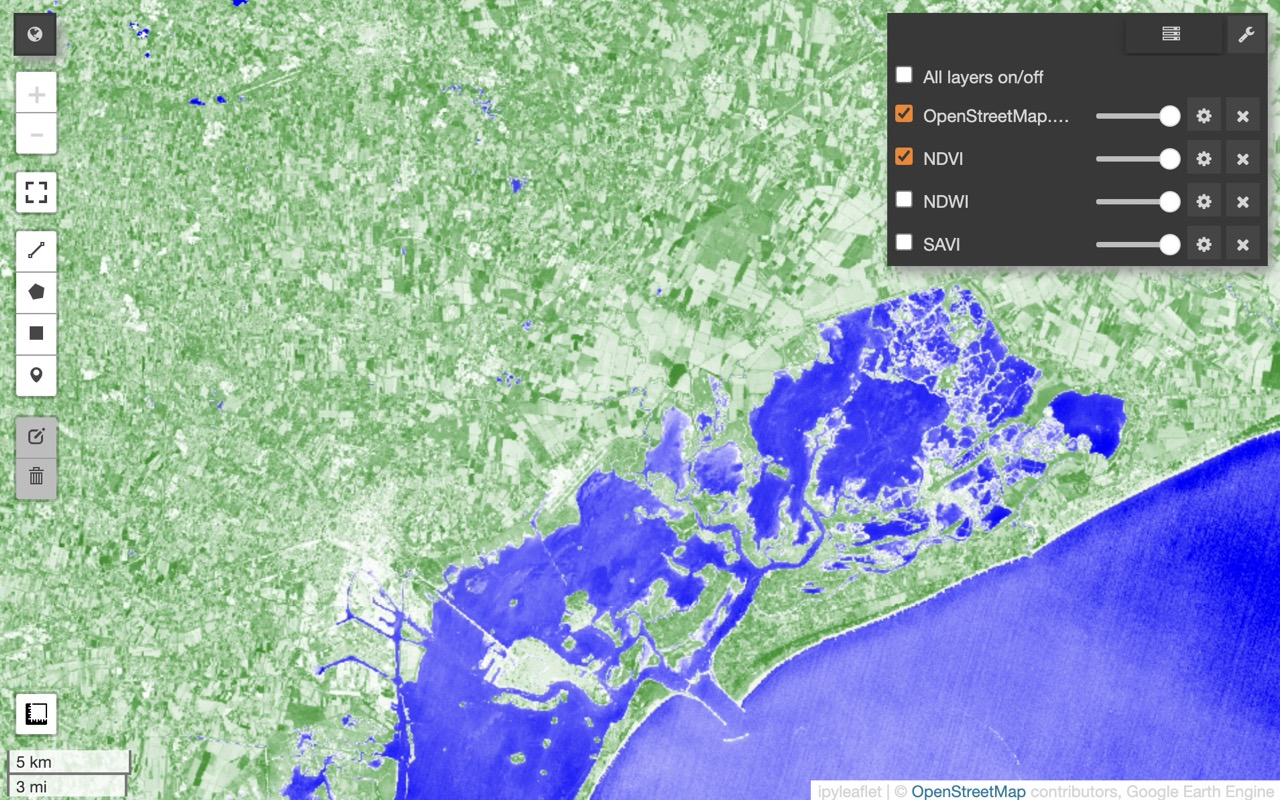

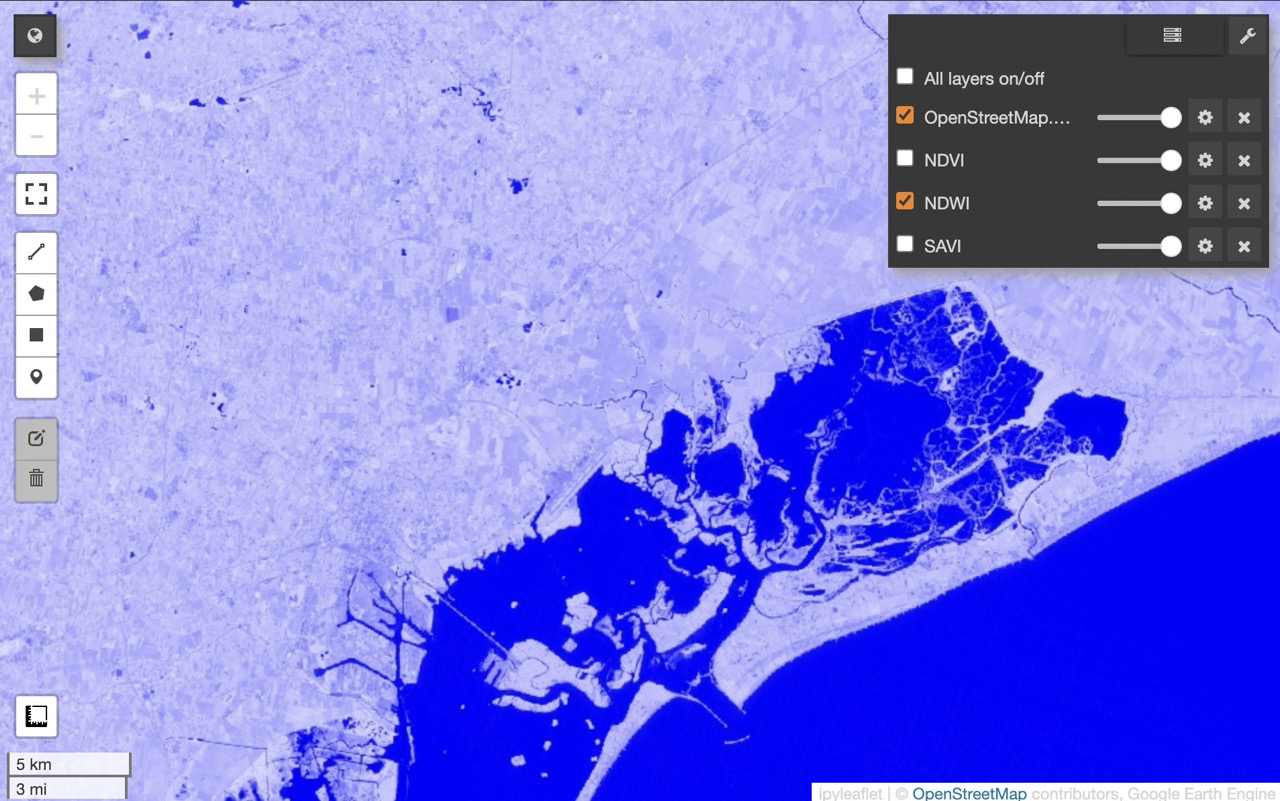

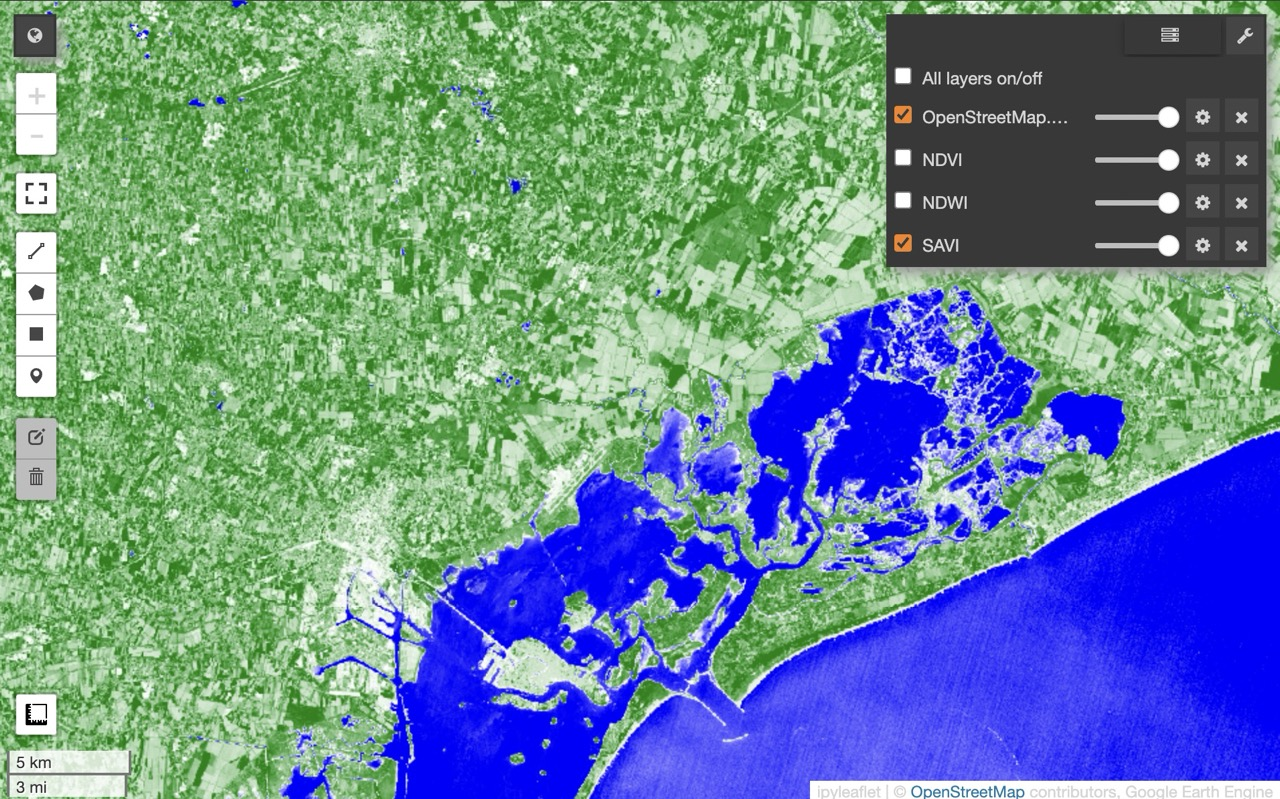

In [ ]:
veg = geemap.Map()

tigercensus = ee.FeatureCollection('TIGER/2018/Counties')
WA = tigercensus.filter(ee.Filter.eq('STATEFP', '53'))
veg.centerObject(WA, 7)

sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

image = sentinel2.filterDate('2023-01-01', '2023-12-31').median()

washington = ee.FeatureCollection('TIGER/2018/States').filter(ee.Filter.eq('NAME', 'Washington'))
image = image.clip(washington)

veg.setCenter(-120.7, 47.7, 7)
veg.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500}, 'Sentinel-2 Image')

def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

image = add_ndwi(image)

vis_params = {
    'bands': ['NDWI'],
    'min': -1,
    'max': 1,
    'palette': ['white', 'blue']
}
veg.addLayer(image, vis_params, 'NDWI')

def add_ndti(image):
    ndti = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands(ndti)

image = add_ndti(image)

vis_params = {
    'bands': ['NDMI'],
    'min': -0.5,
    'max': 0.5,
    'palette': ['red', 'white', 'blue']
}
veg.addLayer(image, vis_params, 'NDMI')

def calculate_savi(image):
    L = 0.5
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + L)) * (1 + L)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'L': L
        }
    )
    return savi.rename('SAVI')

savi_image = calculate_savi(image)

vis_params = {
    'min': 0,
    'max': 1,
    'palette': [
        '#654321',  # Dark Brown
        '#FFFF00',  # Yellow
        '#00FF00'   # Green
    ]
}

veg.addLayer(savi_image, vis_params, 'SAVI')

veg

Map(center=[47.7, -120.7], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# 2.1 Geemap Introduction

## A. True-Color Visualization

In this lab, we will be using the [Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#description) dataset. It is always helpful to review the metadata in any dataset you are using, so look under the "Bands" and "Image Properties" tabs to familiarize yourself with this dataset.

In [ ]:
# Create New Map

TC_Map = geemap.Map()

# Get Sentinel Image Collection
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")   # Sentinel ImageCollection
    .filterDate('2021-01-01', '2022-12-31')             # Filter to 2022
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)) # Filter non-cloud covered image
)

# Go from ImageCollection to single Image
image = collection.median()

TCvis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
}

TC_Map.setCenter(-83.96, 35.96, 12) # Knoxville Coordinates and 12 zoom
TC_Map.addLayer(image, TCvis, 'True Color')
TC_Map

Map(center=[35.96, -83.96], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

## B. False-Color Visualization

In [ ]:
FC_Map = geemap.Map()

FCvis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B8', 'B4', 'B3'],
}

FC_Map.setCenter(-83.96, 35.96, 12) # Knoxville Coordinates and 12 zoom
FC_Map.addLayer(image, FCvis, 'NIR')

FC_Map

Map(center=[35.96, -83.96], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

## C. Clipping Images

We will use the [TIGER US Census Counties](https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_Counties) dataset, which is available in Earth Engine Data Catalog to focus our image on a select area. Look under the "Table Schema" section to familiarize yourself with the data.

We can do the same thing, but for National Boundaries with [FAO GAUL](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_SIMPLIFIED_500m_2015_level0#table-schema)

In [ ]:
County_Map = geemap.Map(center=[39.82, -98.58], zoom=4)
County_Map

Map(center=[39.82, -98.58], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
counties = ee.FeatureCollection('TIGER/2018/Counties')

County_Map.addLayer(counties, {}, 'Counties')

In [ ]:
knox = counties.filter(ee.Filter.eq('NAME', 'Knox'))
County_Map.addLayer(knox, {}, 'Knox')

In [ ]:
knoxTN = knox.filter(ee.Filter.eq('STATEFP', '47'))
County_Map.addLayer(knoxTN, {}, 'Knox TN')
Map.centerObject(knoxTN, 10)

In [ ]:
Clip_Map = geemap.Map()

knoxTC = image.clipToCollection(knoxTN)
Clip_Map.addLayer(knoxTC, TCvis, 'Knox TN TC')
Clip_Map.centerObject(knoxTN, 10)

Clip_Map

Map(center=[35.993196068178555, -83.93723059189078], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
knoxFC = image.clipToCollection(knoxTN)
Clip_Map.addLayer(knoxFC, FCvis, 'Knox TN FC')
Clip_Map.centerObject(knoxTN, 10)

# 2.2 Spectral Indices


Though our band values alone can tell us a lot about a landscape, we can gain more information by performing computations with our bands as variables! We call the products of these calculation Spectral Indices (Index, singular).

Here are just a few examples of different indices we can calculate from our image bands:

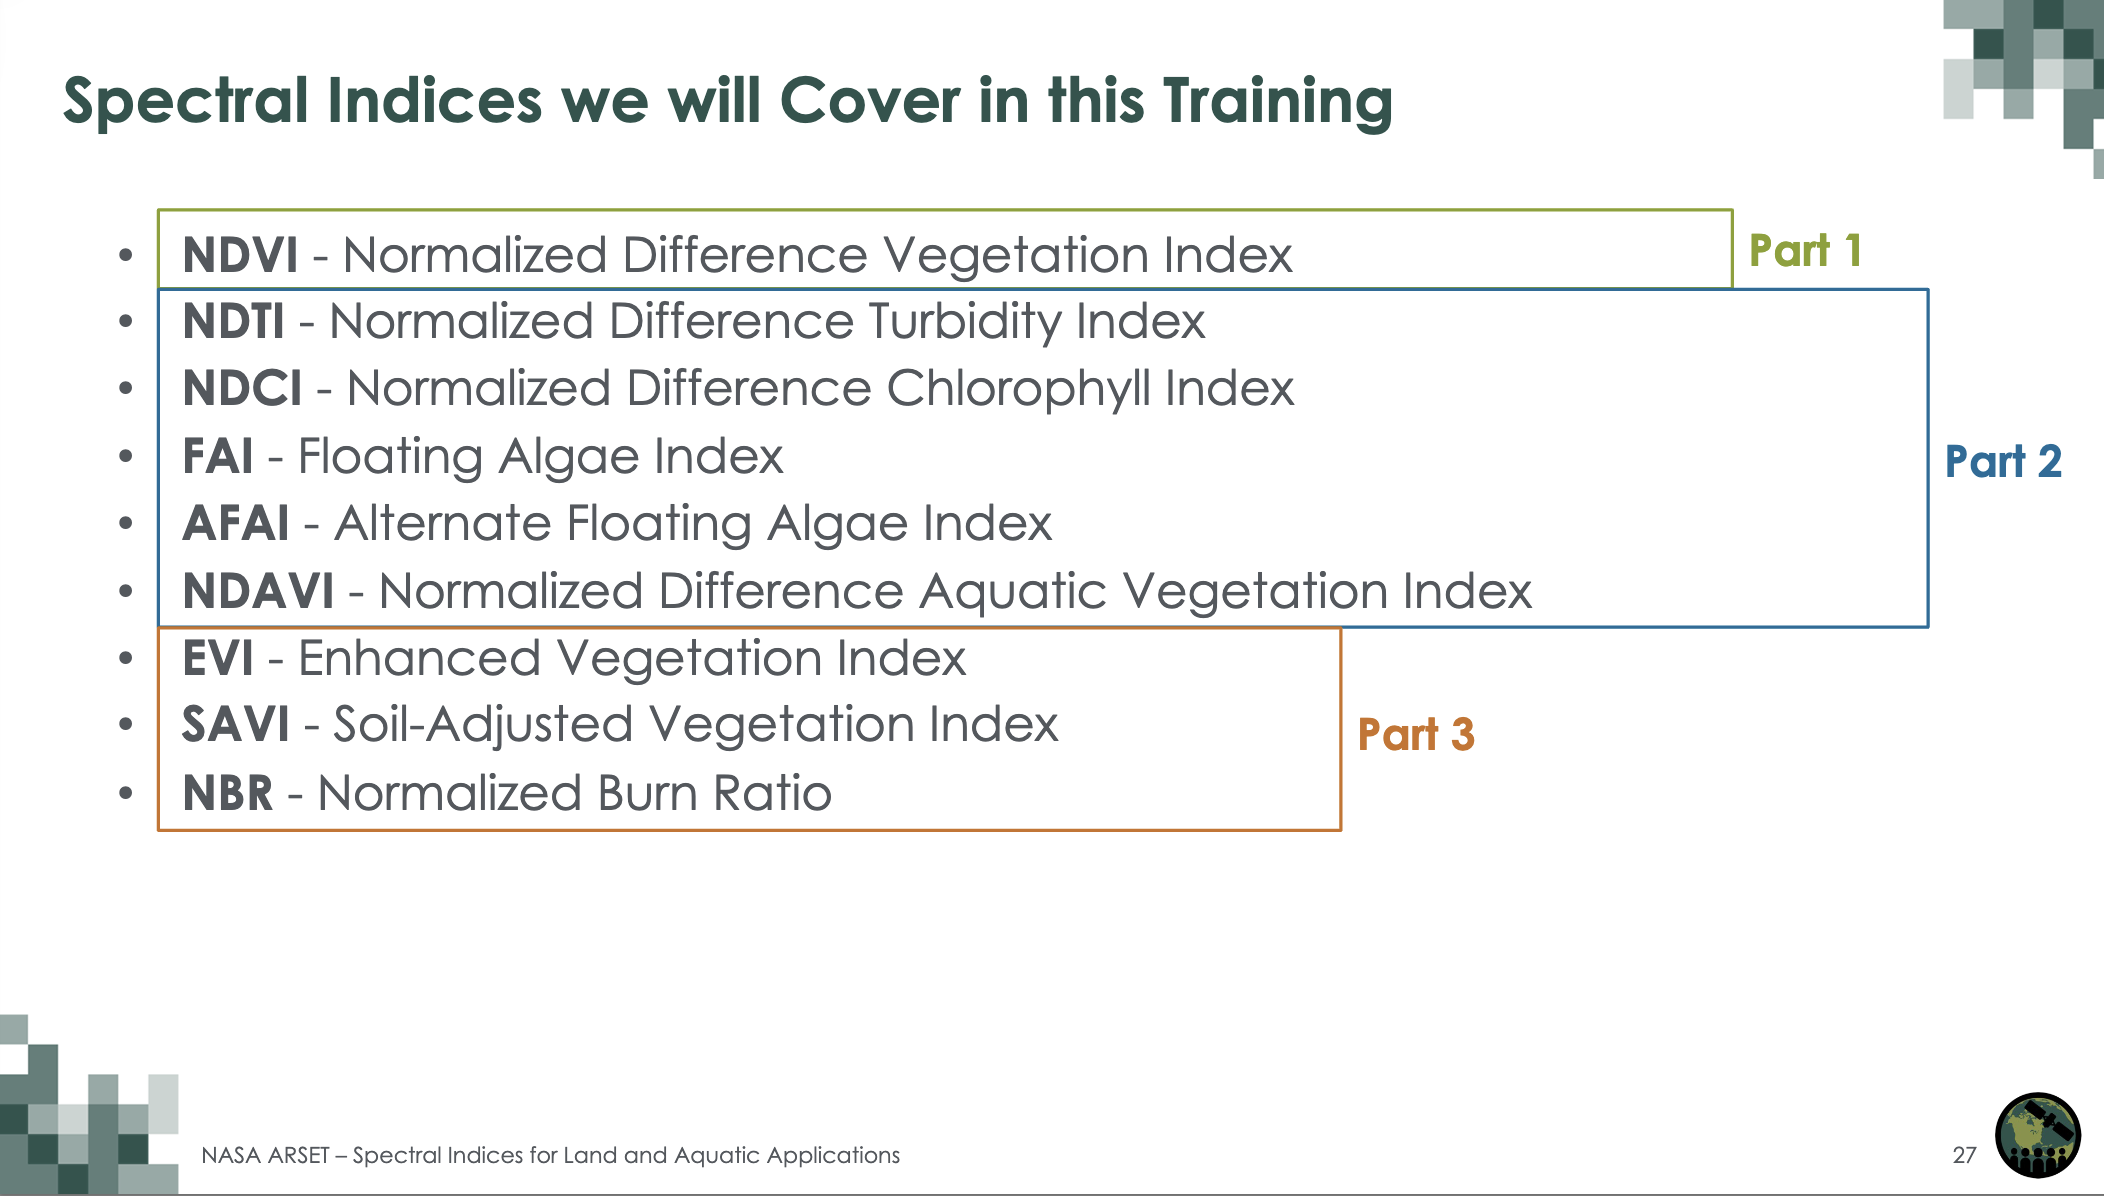

In [ ]:
# Load Sentinel-2 image collection
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# Filter the collection for a specific date and location
image = sentinel2.filterDate('2023-01-01', '2023-12-31').median()

# Define the region of interest
louisianna = ee.FeatureCollection('TIGER/2018/States').filter(ee.Filter.eq('NAME', 'Louisiana'))
image = image.clip(louisianna)

custom = geemap.Map()
custom.setCenter(-90.16, 30.19, 10)
custom.addLayer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500}, 'Sentinel-2 Image')
custom

Map(center=[30.19, -90.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### A. NDVI

Normalized Difference Vegitation Index

In [ ]:
# Define the NDVI calculation using normalizedDifference
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Apply the NDVI calculation
image = add_ndvi(image)

# Add the NDVI layer to the map
vis_params = {
    'bands': ['NDVI'],
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

map1 = geemap.Map()
map1.setCenter(-90.16, 30.19, 10)
map1.addLayer(image, vis_params, 'NDVI')
map1

Map(center=[30.19, -90.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### B. NDWI

Normalized Difference Water Index

In [ ]:
# Define the NDWI calculation using normalizedDifference
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

# Apply the NDWI calculation
image = add_ndwi(image)

# Add the NDWI layer to the map
vis_params = {
    'bands': ['NDWI'],
    'min': -1,
    'max': 1,
    'palette': ['white', 'blue']
}

map2 = geemap.Map()
map2.setCenter(-90.16, 30.19, 10)
map2.addLayer(image, vis_params, 'NDWI')
map2

Map(center=[30.19, -90.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### C. NDMI

Normalized Difference Moisture Index

In [ ]:
# Define the NDTI calculation using normalizedDifference
def add_ndmi(image):
    ndmi = image.normalizedDifference(['B8', 'B11']).rename('NDMI')
    return image.addBands(ndmi)

# Apply the NDMI calculation
image = add_ndmi(image)

# Add the NDMI layer to the map
vis_params = {
    'bands': ['NDMI'],
    'min': -0.5,
    'max': 0.5,
    'palette': ['red', 'white', 'blue']
}

map3 = geemap.Map()
map3.setCenter(-90.16, 30.19, 10)
map3.addLayer(image, vis_params, 'NDMI')
map3

Map(center=[30.19, -90.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### D. SAVI

Soil-Adjusted Vegitation Index

Sometimes we need to look at vegitation differences in sparsely vegitated areas. SAVI helps us do that. Since SAVI is not a Normalized Difference Index, we need to do a couple steps differently to get the right output.

In [ ]:
# Define a function to calculate SAVI
def calculate_savi(image):
    # Define the soil brightness correction factor
    L = 0.5
    # Calculate SAVI
    savi = image.expression(
        '((NIR - RED) / (NIR + RED + L)) * (1 + L)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'L': L
        }
    )
    return savi.rename('SAVI')

# Calculate SAVI
savi_image = calculate_savi(image)

# Define visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': [
        '#654321',  # Dark Brown
        '#FFFF00',  # Yellow
        '#00FF00'   # Green
    ]
}

# Add the SAVI layer to the map
map4 = geemap.Map()
map4.setCenter(-90.16, 30.19, 10)
map4.addLayer(savi_image, vis_params, 'SAVI')
map4

Map(center=[30.19, -90.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

## Case Study: Using Normalized Burn Ratio to Assess Fire Damage

In August 2020, a rare dry lighting storm ignited what would become the [largest wildfire](https://www.fs.usda.gov/detail/mendocino/home/?cid=FSEPRD860382) in California history, destorying over 1,000,000 acres in Northen California. In this example, we will use Sentinel-2 imagery to display a timeseries inspector map that will display a section of the damage.

In [ ]:
# Load Sentinel-2 surface reflectance data.
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# Filter the Sentinel-2 collection

point1 = ee.Geometry.Point([-123.53, 39.37])

sentinel2_images = sentinel2 \
    .filterDate('2020-08-11', '2020-10-04') \
    .filterBounds(point1) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

point2 = ee.Geometry.Point([-122.52, 39.37])

sentinel2_images2 = sentinel2 \
    .filterDate('2020-08-11', '2020-10-04') \
    .filterBounds(point2) \
    .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

In [ ]:
dates = sentinel2_images2.aggregate_array('system:index').getInfo()
# Rename images in 'YYYY-MM-DD'
dates = [date.split('_')[0] for date in dates]
dates = [date.replace('T', '-') for date in dates]
dates

['20200812-184921',
 '20200815-185921',
 '20200817-184919',
 '20200820-185919',
 '20200822-184921',
 '20200825-185921',
 '20200827-184919',
 '20200830-185919',
 '20200901-184921',
 '20200904-185921',
 '20200906-184919',
 '20200909-185929',
 '20200911-184951',
 '20200914-190021',
 '20200916-184939',
 '20200919-185959',
 '20200921-185101',
 '20200924-190131',
 '20200926-185049',
 '20200929-190109',
 '20201001-185221']

In [ ]:
# Compute NBR for Image Collections
nbr_images = sentinel2_images2.map(lambda image: image.normalizedDifference(['B8', 'B12']))

time = geemap.Map()

# Define visualization parameters
vis_params = {
    'min': -0.5,
    'max': 0.5,
    'palette': [
        'red',  # Dark Brown
        'yellow',  # Yellow
        'green'   # Green
    ]
}

# Create timerseries inspector
time.ts_inspector(
    left_ts=nbr_images,     # Left-side dataset
    right_ts=nbr_images,    # Right-side dataset
    left_names=dates,       # Dropbox options list (Left)
    right_names=dates,      # Dropbox options list (Right)
    left_vis=vis_params,    # Visualization parameters (Left)
    right_vis=vis_params,   # Visualization parameters (Right)
    width='80px',           # Dropbox size
)

time.centerObject(point2, 8)
time

Map(center=[39.37, -122.51999999999998], controls=(WidgetControl(options=['position', 'transparent_bg'], widge…